In [ ]:
# Install the `ijson` library for efficient, incremental JSON parsing (especially useful for large files)
!pip install ijson

# Install `ftfy` (Fixes Text For You) for fixing Unicode text issues,
# `regex` for enhanced regular expression support (beyond Python's built-in `re`),
# and `tqdm` for progress bars to visualize loops and operations
!pip install ftfy regex tqdm

# Install `langdetect`, a language detection library to identify the language of a given text (useful for filtering non-English tweets)
!pip install langdetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 51.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=cb631ca5a514f919bd7928fdd156f0e14f4d3fbb22ab0e36fe6640c29971549a
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import os
import json
import random
import pickle
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import ijson
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/TwiBot-22/TwiBot-22/"

Mounted at /content/drive


In [ ]:
# Load user.json, label.csv, split.csv, tweet files (tweet_0.json to tweet_8.json)

user_path = os.path.join(data_dir, "user.json")

def clean_user_id(uid):
    return int(uid[1:]) if isinstance(uid, str) and uid.startswith('u') else int(uid)

def load_user_df(user_path, max_users=None):
    user_data = []

    with open(user_path, 'r') as f:
        first_char = f.read(1)
        f.seek(0)

        if first_char == '[':
            users = json.load(f)
        else:
            users = [json.loads(line) for line in f]

    if max_users:
        users = users[:max_users]

    for user in users:
        user_data.append({
            'id': user['id'],
            'name': user.get('name', ''),
            'username': user.get('username', ''),
            'description': user.get('description', ''),
            'location': user.get('location', ''),
            'followers_count': user.get('public_metrics', {}).get('followers_count', 0),
            'following_count': user.get('public_metrics', {}).get('following_count', 0),
            'tweet_count': user.get('public_metrics', {}).get('tweet_count', 0),
            'listed_count': user.get('public_metrics', {}).get('listed_count', 0),
            'created_at': user.get('created_at', ''),
            'profile_image_url': user.get('profile_image_url', ''),
            'url': user.get('url', ''),
            'verified': user.get('verified', False)
        })

    # Define user_df
    user_df = pd.DataFrame(user_data)

    # Compute behavioral features
    user_df['follower_following_ratio'] = user_df['followers_count'] / (user_df['following_count'] + 1)
    user_df['log_followers'] = np.log1p(user_df['followers_count'])
    user_df['log_following'] = np.log1p(user_df['following_count'])
    user_df['log_tweet_count'] = np.log1p(user_df['tweet_count'])

    return user_df

# Load labels
def load_labels(label_path):
    labels_df = pd.read_csv(label_path)
    label_dict = dict(zip(labels_df['id'], labels_df['label']))
    return label_dict

# Load split info
def load_split(split_path):
    split_df = pd.read_csv(split_path)
    split_dict = dict(zip(split_df['id'], split_df['split']))
    return split_dict

# Load tweets and map user_id to list of tweets (up to 10 most recent):
  # Iterates through the 9 files (tweet_0.json to tweet_8.json).
  # Reads each file line-by-line (so it's memory-efficient).
  # Extracts the tweet text and groups them by author_id in a dictionary.
  # Keeps only the first 10 tweets per user (user_tweets[uid] = user_tweets[uid][:10]).

def stream_tweets_by_user_from_all_files(data_dir, target_user_ids, max_per_user=10):
    user_tweets = defaultdict(list)

    # List all tweet files (assuming they are named like 'tweet_0.json', 'tweet_1.json', ...)
    tweet_files = [f for f in os.listdir(data_dir) if f.startswith('tweet_') and f.endswith('.json')]

    print(f"📂 Found {len(tweet_files)} tweet files to process.")

    # Process each tweet file
    for tweet_file in tweet_files:
        tweet_path = os.path.join(data_dir, tweet_file)
        print(f"📄 Streaming file: {tweet_file}")

        with open(tweet_path, 'r') as f:
            tweets = ijson.items(f, 'item')  # 'item' means stream items of top-level array

            for tweet in tqdm(tweets, desc=f"Processing {tweet_file}"):
                author_id = tweet.get('author_id')
                if author_id in target_user_ids:
                    user_tweets[author_id].append(tweet.get('text', ''))
                    if len(user_tweets[author_id]) >= max_per_user:
                        target_user_ids.remove(author_id)
                if not target_user_ids:
                    break  # stop once all needed users are done

        if not target_user_ids:
            break  # If all users are processed, stop processing files

    return dict(user_tweets)


# ================================================================================================================

# 1. Load user data (first "max_users" users)
print("Loading user data...")
user_df = load_user_df(user_path, max_users=1000000)
user_df["id"] = user_df["id"].apply(clean_user_id)

# Convert to int if the IDs have 'u' prefix or are stored as strings
sample_user_ids = set(int(uid[1:]) if isinstance(uid, str) and uid.startswith('u') else int(uid) for uid in user_df["id"])

# Progress bar for loading users
for _ in tqdm(user_df.itertuples(), total=len(user_df), desc="Loading users"):
    pass  # Simulating progress for loading users (you can add logic here if needed)

# ================================================================================================================

# 2. Load labels and split
label_dict = load_labels(os.path.join(data_dir, "label.csv"))
label_dict = {clean_user_id(uid): label for uid, label in label_dict.items()}

split_dict = load_split(os.path.join(data_dir, "split.csv"))
split_dict = {clean_user_id(uid): split for uid, split in split_dict.items()}

# ================================================================================================================

# 3. Load tweets for the sampled users with a progress bar
print("Loading tweets for users...")

#sample_user_ids = set(user_df["id"].tolist())  # Assuming sample_user_ids are the ones you want to process
user_tweets = stream_tweets_by_user_from_all_files(data_dir, sample_user_ids.copy(), max_per_user=10)

print("Data loading complete.")

Loading user data...


Loading users: 100%|██████████| 1000000/1000000 [00:02<00:00, 456169.67it/s]


Loading tweets for users...
📂 Found 9 tweet files to process.
📄 Streaming file: tweet_2.json


Processing tweet_2.json: 10000000it [03:42, 44953.97it/s]


📄 Streaming file: tweet_1.json


Processing tweet_1.json: 10000000it [04:01, 41447.35it/s]


📄 Streaming file: tweet_3.json


Processing tweet_3.json: 10000000it [03:48, 43854.02it/s]


📄 Streaming file: tweet_4.json


Processing tweet_4.json: 10000000it [03:53, 42754.81it/s]


📄 Streaming file: tweet_5.json


Processing tweet_5.json: 10000000it [04:39, 35808.95it/s]


📄 Streaming file: tweet_6.json


Processing tweet_6.json: 10000000it [04:10, 39923.54it/s]


📄 Streaming file: tweet_7.json


Processing tweet_7.json: 10000000it [04:17, 38837.28it/s]


📄 Streaming file: tweet_8.json


Processing tweet_8.json: 8217457it [03:47, 36071.04it/s]


📄 Streaming file: tweet_0.json


Processing tweet_0.json: 10000000it [04:29, 37143.25it/s]


Data loading complete.


In [ ]:
# Display user DataFrame
display(user_df.head())

,id,name,username,description,location,followers_count,following_count,tweet_count,listed_count,created_at,profile_image_url,url,verified,follower_following_ratio,log_followers,log_following,log_tweet_count
0,1217628182611927040,Boaz Barak,boazbaraktcs,Theoretical Computer Scientist. See also https...,"Cambridge, MA",7316,215,3098,69,2020-01-16 02:02:55+00:00,https://pbs.twimg.com/profile_images/125226236...,https://t.co/BoMip9FF17,False,33.870370,8.897956,5.375278,8.038835
1,2664730894,olawale 💨,wale_io,creative _,🎈,123,1090,1823,0,2014-07-02 17:56:46+00:00,https://pbs.twimg.com/profile_images/147837638...,,False,0.112741,4.820282,6.994850,7.508787
2,1266703520205549568,panagiota_.b,b_panagiota,👽,None,3,62,66,0,2020-05-30 12:10:45+00:00,https://pbs.twimg.com/profile_images/142608606...,,False,0.047619,1.386294,4.143135,4.204693
3,1089159225148882949,"Jacqueline Hodges, MD MPH",jachodges_md,mama to maya. ABIM research pathway fellow @UV...,"Charlottesville, VA",350,577,237,1,2019-01-26 13:52:49+00:00,https://pbs.twimg.com/profile_images/130229171...,,False,0.605536,5.860786,6.359574,5.472271
4,36741729,Matthew Stubblefield,Matthew_Brody,Father / SWT Alumnus / Longhorn Fan,United States,240,297,3713,8,2009-04-30 19:01:42+00:00,https://pbs.twimg.com/profile_images/145808462...,,False,0.805369,5.484797,5.697093,8.219865


In [ ]:
print("Sample user_df IDs:", user_df["id"].head().tolist())
print("Sample label_dict keys:", list(label_dict.keys())[:5])
print("Sample split_dict keys:", list(split_dict.keys())[:5])
print("Sample user_tweets keys:", list(user_tweets.keys())[:5])

Sample user_df IDs: [1217628182611927040, 2664730894, 1266703520205549568, 1089159225148882949, 36741729]
Sample label_dict keys: [1217628182611927040, 2664730894, 1266703520205549568, 1089159225148882949, 36741729]
Sample split_dict keys: [2664730894, 1089159225148882949, 36741729, 1679822588, 1519144464]
Sample user_tweets keys: [2165095428, 3009562656, 352586927, 385203914, 1384088969860714498]


In [ ]:
# Show first 5 items from label_dict
for i, (k, v) in enumerate(label_dict.items()):
    print(f"{k}: {v}")
    if i == 4: break

1217628182611927040: human
2664730894: human
1266703520205549568: human
1089159225148882949: human
36741729: bot


In [ ]:
# Show first 5 items from split_dict
for i, (k, v) in enumerate(split_dict.items()):
    print(f"{k}: {v}")
    if i == 4: break

2664730894: train
1089159225148882949: train
36741729: train
1679822588: train
1519144464: train


In [ ]:
# Show first 3 users and their tweets
for i, (uid, tweets) in enumerate(user_tweets.items()):
    print(f"User ID: {uid}")
    for t in tweets:
        print("  -", t)
    if i == 2: break

User ID: 2165095428
  - With the help of the #RightEye, Dr. Renaud of EagleEye Performance Vision help a young boy overcome his #vision issues that were holding him back in #school, #athletics and basic life activities. See why he was selected as a 2020 Impact Award Finalist: https://t.co/DDCAedtyfZ. https://t.co/nGgV10U3L3
  - RT @iptkids: @righteyeinsight @whenkidsfly We love our #righteye! ❤️
  - RT @seco_intl: Starring @righteyeinsight!
  - RT @brainline: Here are 9 1/2 facts to share with others. What other facts have you learned that could make this a list of 10 (or more)? #T…
  - RT @CDCInjury: #Suicide &amp; falls have surpassed motor vehicle crashes as the leading categories of TBI-related death in the US. We can do mo…
  - RT @brainenergyteam: Brain injury fact: brain injuries do not discriminate. In this piece, writer and stroke survivor Isaac Peterson discus…
  - RT @cattonline: "Immediate recognition is really the key" —
@sbwellr talks #concussion education in #BC sport &a

In [ ]:
# Sample Tweets

tweet_path = "/content/drive/MyDrive/TwiBot-22/TwiBot-22/tweet_0.json"

with open(tweet_path, 'r') as f:
    tweets = ijson.items(f, 'item')  # stream each item in the top-level list

    for i, tweet in enumerate(tweets):
        print(f"Tweet {i + 1}:")
        print("  author_id:", tweet.get("author_id"), "type:", type(tweet.get("author_id")))
        print("  text:", tweet.get("text", "")[:100])  # preview first 100 chars
        if i >= 4:
            break  # only check first 5 tweets


Tweet 1:
  author_id: 1304855289208819713 type: <class 'int'>
  text: @phaseknight_ Although I didn't base this sketch on you specifically, I really think it vibes with y
Tweet 2:
  author_id: 1304855289208819713 type: <class 'int'>
  text: I mean, doesn't his beautiful face just scream Trinket?! 🥺 @matthewmercer @CriticalRole @TitmouseInc
Tweet 3:
  author_id: 1304855289208819713 type: <class 'int'>
  text: @Cobalt_han I'm British, so that used to be me too! Now I live in Alaska! 🐻
Tweet 4:
  author_id: 1304855289208819713 type: <class 'int'>
  text: RT @itsginnydi: the only thing better than the Legend of Vox Machina will be the Legend of Vox Machi
Tweet 5:
  author_id: 1304855289208819713 type: <class 'int'>
  text: Lucky and his sister, among other bears, were orphaned as cubs by human behavior. Due to the lack of


**Data Analysis:**

In [ ]:
# Basic statistics
print("🧾 Basic Info:")
print(f"Total users in user_df: {len(user_df)}")  # Number of users loaded from user_df
print(f"Labeled users in label_dict: {len(label_dict)}")  # Number of labeled users
print(f"Users with tweets: {len(user_tweets)}")  # Number of users that have tweets
print(f"Total tweets: {sum(len(tweets) for tweets in user_tweets.values())}")  # Total number of tweets for those users


🧾 Basic Info:
Total users in user_df: 1000000
Labeled users in label_dict: 1000000
Users with tweets: 933872
Total tweets: 9062601


User counts by split:
train    700000
val      200000
test     100000
Name: count, dtype: int64


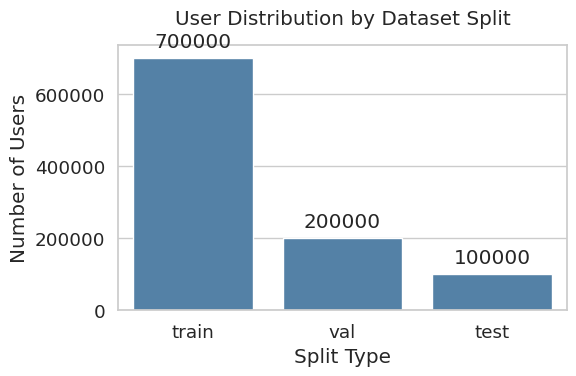

In [ ]:
# Split distribution
# Convert the values from split_dict (which maps user IDs to split type) into a pandas Series

split_series = pd.Series(list(split_dict.values()))

# Count the number of users in each split (train, val, test)
split_counts = split_series.value_counts()

print("User counts by split:")
print(split_counts)

# Set a clean Seaborn theme for the plot with larger fonts
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    x=split_counts.index,
    y=split_counts.values,
    color="steelblue",
    ax=ax
)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

ax.set_title("User Distribution by Dataset Split", pad=15)
ax.set_xlabel("Split Type")
ax.set_ylabel("Number of Users")

plt.tight_layout()
plt.show()


Label counts:
human    860057
bot      139943
Name: count, dtype: int64


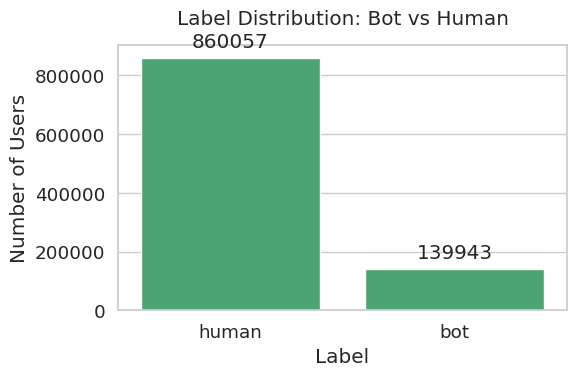

In [ ]:
# Assuming label_dict = {'user1': 'bot', 'user2': 'human', ...}
# Convert the label dictionary to a pandas Series where index = user ID, value = label

label_series = pd.Series(label_dict)
label_counts = label_series.value_counts()

# Print label counts
print("Label counts:")
print(label_counts)

# Set style
sns.set_theme(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(6,4))

# Barplot with future-proof style
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    color="mediumseagreen",  # Use a clear color (no palette warning)
    ax=ax
)

# Annotate bars
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(
        f"{int(height)}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

# Labels and title
ax.set_title("Label Distribution: Bot vs Human", pad=15)
ax.set_xlabel("Label")
ax.set_ylabel("Number of Users")

# Tight layout
plt.tight_layout()
plt.show()


Tweet count per user — Min: 1, Max: 10, Mean: 9.70


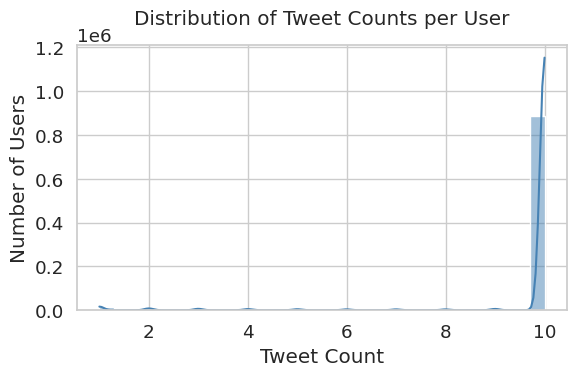

In [ ]:
# Tweet count per user
# Calculate the number of tweets per user by measuring the length of each user's tweet list
tweet_lengths = [len(tweets) for tweets in user_tweets.values()]

# Print summary statistics
print(f"Tweet count per user — Min: {min(tweet_lengths)}, Max: {max(tweet_lengths)}, Mean: {sum(tweet_lengths)/len(tweet_lengths):.2f}")

# Set style
sns.set_theme(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(6, 4))

# Histogram with KDE
sns.histplot(
    tweet_lengths,
    bins=30,
    kde=True,
    color="steelblue",
    edgecolor="white",
    ax=ax
)

# Labels and title
ax.set_title("Distribution of Tweet Counts per User", pad=15)
ax.set_xlabel("Tweet Count")
ax.set_ylabel("Number of Users")

# Tweak layout
plt.tight_layout()
plt.show()


In [ ]:
print(f"✅ Loaded tweets for {len(user_tweets)} users.")


✅ Loaded tweets for 933872 users.


In [ ]:
# --- Print summary statistics ---
print("\n📌 Summary Statistics:")
print(f"Average tweets/user: {sum(tweet_lengths)/len(tweet_lengths):.2f}")
print(f"Max tweets for one user: {max(tweet_lengths)}")
print(f"Min tweets for one user: {min(tweet_lengths)}")


📌 Summary Statistics:
Average tweets/user: 9.70
Max tweets for one user: 10
Min tweets for one user: 1


**Data Quality Check:**

In [ ]:
# 📊 Data Quality Check — Observation Only (No Filtering Yet)

print("\n📊 Data Quality Checks")

# --- User Profile Checks ---
print("\n✅ User Profile Quality:")
print("Missing 'description':", user_df['description'].isna().sum())
print("Missing 'username':", user_df['username'].isna().sum())
print("Users with empty 'description':", (user_df['description'].str.strip() == '').sum())
print("Users with zero followers:", (user_df['followers_count'] == 0).sum())
print("Users with zero following:", (user_df['following_count'] == 0).sum())
print("Users with zero tweets:", (user_df['tweet_count'] == 0).sum())

# --- Tweet Quality Checks ---
all_tweets = [tweet for tweets in user_tweets.values() for tweet in tweets]
print("\n✅ Tweet Quality:")
print("Total tweets:", len(all_tweets))
print("Empty tweets:", sum(1 for t in all_tweets if not t.strip()))
print("Average tweet length:", np.mean([len(t) for t in all_tweets]))
print("Max tweet length:", max(len(t) for t in all_tweets))
print("Duplicate tweets:", len(all_tweets) - len(set(all_tweets)))

# --- ID Cross Check ---
print("\n✅ ID Sanity Checks:")
print("user_df entries:", len(user_df))
print("label_dict entries:", len(label_dict))
print("user_tweets users:", len(user_tweets))
print("Common users (intersection):", len(set(user_df['id']) & set(label_dict.keys()) & set(user_tweets.keys())))



📊 Data Quality Checks

✅ User Profile Quality:
Missing 'description': 0
Missing 'username': 0
Users with empty 'description': 124231
Users with zero followers: 17237
Users with zero following: 10647
Users with zero tweets: 28308

✅ Tweet Quality:
Total tweets: 9062601
Empty tweets: 0
Average tweet length: 129.37218310725586
Max tweet length: 1040
Duplicate tweets: 641794

✅ ID Sanity Checks:
user_df entries: 1000000
label_dict entries: 1000000
user_tweets users: 933872
Common users (intersection): 933872


In [ ]:
# Language Detection for Descriptions
# This block does not modify user_df, nor does it help filter the data. It's just diagnostic to see the distribution of languages.

print("\n🌍 Detecting language for ALL user descriptions...")

desc_langs = [] # List to store detected languages for each user description

# Iterate through the 'description' column in the user DataFrame
# Fill NaNs with empty strings and ensure all entries are strings
for desc in user_df['description'].fillna('').astype(str):
    try:
        # Try to detect the language of the description
        lang = detect(desc)
        desc_langs.append(lang)
    except LangDetectException:
        # If detection fails (e.g., very short or empty text), mark as "unknown"
        desc_langs.append("unknown")

# Count how many descriptions are detected in each language
desc_counts = Counter(desc_langs)

# Print the languages and their corresponding counts in descending order
print("📝 Description language counts:")
for lang, count in desc_counts.most_common():
    print(f"{lang}: {count}")

#==============================================================================

# Language Detection for Tweets
# print("\n🌍 Detecting language for ALL tweets...")

# tweet_langs = []
# total_tweets = 0

# for tweet_list in user_tweets.values():
#     for tweet in tweet_list:
#         total_tweets += 1
#         try:
#             lang = detect(tweet)
#             tweet_langs.append(lang)
#         except LangDetectException:
#             tweet_langs.append("unknown")

# tweet_counts = Counter(tweet_langs)
# print("\n🐦 Tweet language counts:")
# for lang, count in tweet_counts.most_common():
#     print(f"{lang}: {count}")

# print(f"\n✅ Total tweets checked: {total_tweets}")



🌍 Detecting language for ALL user descriptions...
📝 Description language counts:
en: 655950
unknown: 135647
es: 48250
de: 20020
fr: 17957
fa: 11116
ja: 10395
ar: 10097
it: 9855
pt: 9666
tr: 6803
nl: 6099
id: 5881
ca: 4499
no: 3663
da: 3352
tl: 3143
ro: 3118
hi: 3006
af: 2985
so: 2494
ko: 2095
cy: 2070
et: 2044
sv: 1861
sw: 1740
fi: 1610
pl: 1250
vi: 1234
ru: 1131
ur: 974
sl: 879
hr: 832
zh-cn: 809
mr: 743
sq: 654
el: 606
ta: 580
hu: 514
ne: 506
th: 497
cs: 483
lt: 469
sk: 420
kn: 330
he: 270
lv: 247
mk: 236
bn: 232
uk: 195
bg: 128
te: 102
zh-tw: 90
ml: 66
gu: 61
pa: 46


**Filter Users:**

In [ ]:
# 1. Perform language filtering by detecting the language of each user’s profile description
# 2. Add the result to the user_df DataFrame
# 3. Then filters users to only keep English ones

# Filter out users with zero tweets
user_df = user_df[user_df["tweet_count"] > 0]

# Detect and filter by English descriptions
from langdetect import detect, LangDetectException

# Define a helper function to detect language with error handling
def detect_lang(text):
    try:
        return detect(text)  # Attempt to detect the language of the input text
    except LangDetectException:
        return "unknown"     # Fallback for empty or undetectable text

print("🌍 Detecting description language for filtering...")

# 1. Adds a new column "description_lang" to user_df, where each entry contains the detected language of the user's profile description
# 2. .astype(str) => Ensures all values are treated as strings — even if some are accidentally numeric or another type. This provides uniform input to the language detector.
# 3. .apply(detect_lang) => This applies your custom detect_lang() function to each cleaned description.
# 4. user_df["description_lang"] = ... => The detected language (e.g., "en", "es", "fr", "unknown") is stored in a new column called "description_lang".
user_df["description_lang"] = user_df["description"].fillna("").astype(str).apply(detect_lang)

# ✅ Keep only users with English descriptions
user_df = user_df[user_df["description_lang"] == "en"]  #Exact filtering step
print(f"Filtered to English descriptions + nonzero tweets: {len(user_df)} users")

# Sync user_tweets and label_dict with filtered user_df => Keep only user IDs that survived the filtering
valid_ids = set(user_df["id"])  # Creates a set of user IDs that passed the filters (English descriptions and nonzero tweets).
user_tweets = {uid: tweets for uid, tweets in user_tweets.items() if uid in valid_ids}  # Filters the user_tweets dictionary to only keep users that are still in user_df.
label_dict = {uid: label for uid, label in label_dict.items() if uid in valid_ids}  # Filter the label_dict, which maps user IDs to their ground-truth labels ("bot" or "human").

🌍 Detecting description language for filtering...


In [ ]:
# Prepares a balanced and meaningful dataset of Twitter users for training and evaluating a bot detection model.

# Loads labels (bot or human).
# Filters out users with fewer than 10 tweets (to ensure meaningful content).
# Selects all qualified bots, and samples humans whose behavior resembles bots.
# Filters all user-related data (user_df, label_dict, user_tweets) to only include these selected users.

# Step 1: Load and clean label.csv ---------------------------------------------------------------------------------------------------
label_df = pd.read_csv(os.path.join(data_dir, "label.csv"))
label_df["id"] = label_df["id"].apply(clean_user_id)  # Ensure user IDs are cleaned and match format used elsewhere
print(f"✅ Loaded labels: {len(label_df)} users")

# Step 2: Separate bot and human users  ---------------------------------------------------------------------------------------------------
bot_ids = label_df[label_df["label"] == "bot"]["id"].tolist()      # Get list of bot user IDs
human_ids = label_df[label_df["label"] == "human"]["id"].tolist()  # Get list of human user IDs
print(f"📊 Bots: {len(bot_ids)} | Humans: {len(human_ids)}")

# Step 3: Filter users with ≥10 tweets ---------------------------------------------------------------------------------------------------
qualified_bot_ids = [uid for uid in bot_ids if len(user_tweets.get(uid, [])) >= 10]     # Keep only bots with ≥10 tweets
qualified_human_ids = [uid for uid in human_ids if len(user_tweets.get(uid, [])) >= 10] # Keep only humans with ≥10 tweets
print(f"✅ Bots with ≥10 tweets: {len(qualified_bot_ids)}")
print(f"✅ Humans with ≥10 tweets: {len(qualified_human_ids)}")

# Step 4: Sample bots + bot-like humans ---------------------------------------------------------------------------------------------------

# Use all qualified bots
sampled_bot_ids = qualified_bot_ids  # Take all bots that passed tweet threshold

# For the selected bots, retrieve their behavioral features => Then, creates a bot_stats DataFrame with these 3 features for all bots:
# log_followers: log-transformed follower count
# log_following: log-transformed following count
# log_tweet_count: log-transformed tweet count
bot_stats = user_df[user_df["id"].isin(sampled_bot_ids)][["log_followers", "log_following", "log_tweet_count"]]

# From all humans with ≥10 tweets, extract those users into human_pool.
human_pool = user_df[user_df["id"].isin(qualified_human_ids)]

# ************************This is a key idea: instead of using random humans, you use "bot-like humans" to make the classification task more realistic and harder.
# Filter human_pool to include only those users who Have fewer followers, followings, and tweets than the 95th percentile of the bots:
similar_humans = human_pool[
    (human_pool["log_followers"] <= bot_stats["log_followers"].quantile(0.95)) &      #If 95% of bots have ≤ 1,000 followers => Only keep humans with ≤ 1,000 followers.
    (human_pool["log_following"] <= bot_stats["log_following"].quantile(0.95)) &
    (human_pool["log_tweet_count"] <= bot_stats["log_tweet_count"].quantile(0.95))
]

# Sample an equal number of humans to match the number of bots
sampled_human_ids = random.sample(similar_humans["id"].tolist(), len(sampled_bot_ids))

# Combine sampled bot and human IDs into one set
sampled_ids = set(sampled_bot_ids + sampled_human_ids)
print(f"🎯 Sampled users: {len(sampled_bot_ids)} bots + {len(sampled_human_ids)} human-like users")

# Step 5: Filter all data to sampled_ids ---------------------------------------------------------------------------------------------------

# Keep only sampled users in user_df
user_df = user_df[user_df["id"].isin(sampled_ids)]
print(f"✅ user_df filtered: {len(user_df)} users")

# Keep only sampled users in label_dict
label_dict = {uid: label_dict[uid] for uid in sampled_ids if uid in label_dict}
print(f"✅ label_dict filtered: {len(label_dict)} users")

# Keep only sampled users in user_tweets
user_tweets = {uid: tweets for uid, tweets in user_tweets.items() if uid in sampled_ids}
print(f"✅ user_tweets filtered: {len(user_tweets)} users")


In [ ]:
# Save everything for training
save_dir = "/content/drive/MyDrive/TwiBot-22/prepared_data"
os.makedirs(save_dir, exist_ok=True)  # Create the save directory if it doesn't exist

# Save selected user IDs (bot + human) used for training
with open(os.path.join(save_dir, "sampled_ids.pkl"), "wb") as f:
    pickle.dump(sampled_ids, f)

# Save the filtered user DataFrame (contains only sampled users and relevant metadata)
user_df.to_pickle(os.path.join(save_dir, "user_df.pkl"))

# Save the label dictionary (user_id → "bot"/"human" label) for sampled users
with open(os.path.join(save_dir, "label_dict.pkl"), "wb") as f:
    pickle.dump(label_dict, f)

# Save the tweet dictionary (user_id → list of tweets) for sampled users
with open(os.path.join(save_dir, "user_tweets.pkl"), "wb") as f:
    pickle.dump(user_tweets, f)

# Save list of sampled bot user IDs
with open(os.path.join(save_dir, "sampled_bot_ids.pkl"), "wb") as f:
    pickle.dump(sampled_bot_ids, f)

# Save list of sampled human user IDs
with open(os.path.join(save_dir, "sampled_human_ids.pkl"), "wb") as f:
    pickle.dump(sampled_human_ids, f)

print("✅ Saved filtered user data to disk.")
